# Isiah Montalvo Evil Geniuses Data Analyst Internship Assessment
To the wonderful person who ends up reviewing this assessment over at Evil Geniuses, I hope this finds you well! Throughout this notebook, I will be answering your required questions and detailing both my analysis and my thought process behind how I choose to explore this dataset. 

## Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.stats import lognorm

In [2]:
df = pd.read_excel("data/social_data.xlsx")

## Data Cleaning
First things first, data cleaning! Python packages tend to dislike whitespace, so we simply remove all leading and trailing whitespace from the data and replace spaces between words with an underscore.

In [3]:
df.columns = [column.replace(" ", "_") for column in df.columns]

In [4]:
columns = ["Account", "Account_Type", "Campaign_Name", "Media_Type"]
for column in columns:
    df[column] = df[column].str.strip().str.replace(" ", "_")

# Tasks: 

## 1) What is the typical engagement rate we can expect? What's the likelihood that we can achieve a 15% engagement rate?
Considering the dataset possesses both engagements and impressions, the engagement rate by impressions will be calculated with the following formula: $$ Engagement Rate  = (\frac{engagements}{impressions}) * 100$$
Typical engagement rate will be interpreted as the average engagement rate of the dataset and will be calculated with the formula: $$ Typical Engagement Rate = (\frac{\sum{engagementRates}}{totalPosts}) * 100$$

In [5]:
def engagementRate(engagements, impressions):
    return (engagements / impressions) * 100

def averageEngagementRate(engagementRates):
    return np.mean(engagementRates)

Looking at the engagement rate formula, we know that the impressions can never be 0 or we risk dividing by 0. We solve this problem by removing all posts with 0 impressions from the dataset.

In [6]:
badIndexes = df.query("Total_Impressions == 0").index
df = df.drop(badIndexes).reset_index(drop=True)

In [7]:
engagementRates = engagementRate(df.Total_Engagements, df.Total_Impressions)
typicalEngagementRate = averageEngagementRate(engagementRates)
print("The typical engagement rate we can expect is {0:.2f}%".format(typicalEngagementRate))

The typical engagement rate we can expect is 40.49%


The average engagement rate here is abnormally high especially since normal engagement rates tend to fall between 1% and 3%. Since numbers this big tend to be caused by large outliers, we begin by checking if any engagement rate is larger than 100%. All engagement rates should be less than or equal to 100% considering it's a ratio. 

In [8]:
if any(er > 100 for er in engagementRates):
    print("Investigate")
else:
    print("All good")

Investigate


In [9]:
df.query("Total_Engagements > Total_Impressions")

,Published_Date,Account,Account_Type,Campaign_Name,Total_Impressions,Total_Engagements,Media_Type
642,2023-03-10 12:37:06,General,FBPAGE,N/A,1,940,Photo
2545,2023-01-19 06:02:34,General,FBPAGE,N/A,5,44,Photo
2725,2023-01-05 11:55:44,General,FBPAGE,N/A,300,3776,Photo


It seems we found the culprit! There are a few post where the total engagements for the post is larger than the total impressions of the post which is impossible. We consider this an error in data collection, delete these posts from the dataset, and recalculate the typical engagement rate.

In [10]:
badIndexes = df.query("Total_Engagements > Total_Impressions").index
df = df.drop(badIndexes).reset_index(drop=True)

In [11]:
engagementRates = engagementRate(df.Total_Engagements, df.Total_Impressions)
typicalEngagementRate = averageEngagementRate(engagementRates)
print("The typical engagement rate we can expect is {0:.2f}%".format(typicalEngagementRate))

The typical engagement rate we can expect is 5.35%


This number makes a lot more sense and has the added bonus of showcasing great engagement from posts on average. 

In [12]:
df["Engagement_Rates"] = engagementRates

To calculate the likelihood of achieving a 15% engagement rate, we can use a probability distributution to determine the probability of achieving such an engagement rate. The problem is, which one to use? We start our investigation by plotting a histogram of the engagement rate values. 

Text(0, 0.5, 'Frequency')

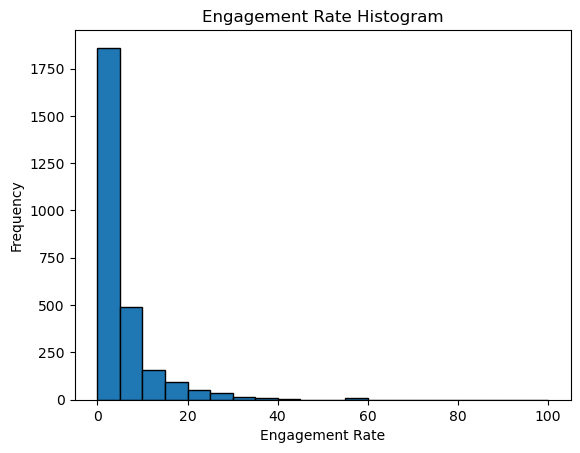

In [13]:
plt.hist(df.Engagement_Rates, edgecolor = "black", bins = 20)
plt.title("Engagement Rate Histogram")
plt.xlabel("Engagement Rate")
plt.ylabel("Frequency")

The engagement rate data seems to follow a right-skewed distribution. The initial impression is that this follows a lognormal distribution. We can test this by transforming the engagement rates using the natural logarithm and plotting the histogram again to see if it follows a normal distribution. 

In [14]:
badIndexes = df.query("Engagement_Rates == 0").index
probDF = df.drop(badIndexes).reset_index(drop=True)

Text(0, 0.5, 'Frequency')

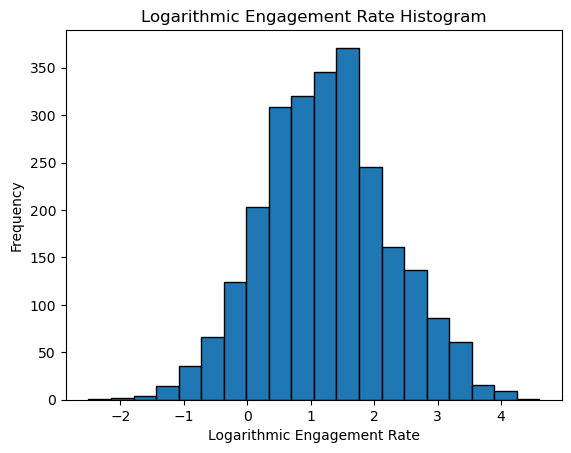

In [15]:
logERS = np.log(probDF.Engagement_Rates)
plt.hist(logERS, edgecolor = "black", bins = 20)
plt.title("Logarithmic Engagement Rate Histogram")
plt.xlabel("Logarithmic Engagement Rate")
plt.ylabel("Frequency")

Bingo! Looks like the initial impression was spot on, the transformed data does indeed follow a normal distribution. From here, we just fit the lognormal distribution to the data and use the cumulative distribution function to calculate the probability of obtaining a 15% engagement rate.

In [16]:
shape, loc, scale = lognorm.fit(df.Engagement_Rates)
probability = 1 - lognorm(shape, loc, scale).cdf(15)
probability = probability * 100
print("The likelihood of achieving a 15% engagement rate is {0:.2f}%".format(probability))

The likelihood of achieving a 15% engagement rate is 7.56%


## 2) Does the day of the week and time of posting affect engagement rates?

To determine if the day or time of posting affects engagement rates, we'll calculate the average engagement rate for each day of the week as well as each hour of the day.

In [17]:
dateDF = df.sort_values("Published_Date")
dateDF.Published_Date.max() - dateDF.Published_Date.min()

Timedelta('87 days 09:09:39.152000')

In [18]:
days = dateDF.groupby(dateDF.Published_Date.dt.weekday)["Engagement_Rates"].mean()
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data = {"Day" : weekdays, "Average_Engagement_Rate": days.values}
days = pd.DataFrame(data)
days.sort_values("Average_Engagement_Rate", inplace = True)

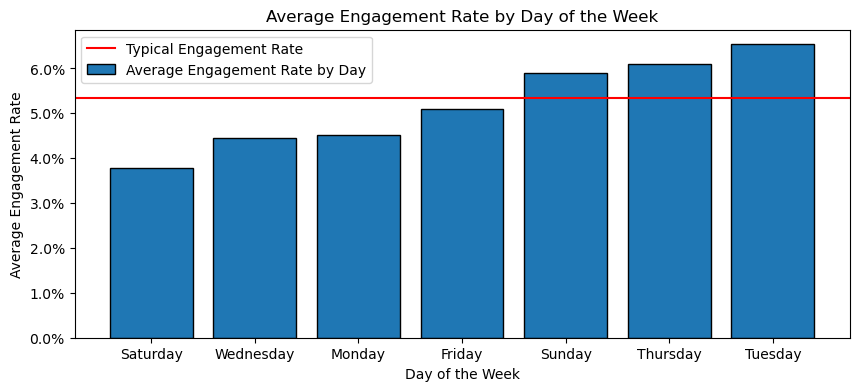

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.bar("Day", "Average_Engagement_Rate", data = days, edgecolor = "black")
ax.axhline(y = typicalEngagementRate, color = "r", linestyle = "-")

plt.title("Average Engagement Rate by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Engagement Rate")
plt.gca().yaxis.set_major_formatter(PercentFormatter())

plt.legend(["Typical Engagement Rate", "Average Engagement Rate by Day"])
plt.show()

In this graph, we can see that Sunday, Thursday, and Tuesday tend to have higher engagement rates than our global average with Saturday having the least engagements. Next we will examine how the time of day affects engagement rates.

In [20]:
hours = dateDF.groupby(dateDF.Published_Date.dt.hour)["Engagement_Rates"].mean()
times = ["2:00am", "3:00am", "4:00am", "5:00am", "6:00am", "7:00am", "8:00am", "9:00am", "10:00am", "11:00am", "12:00pm", 
         "1:00pm", "2:00pm", "3:00pm", "4:00pm", "5:00pm", "6:00pm", "7:00pm", "8:00pm", "9:00pm", "10:00pm", "11:00pm"]
data = {"Hour" : times, "Average_Engagement_Rate": hours.values}
hours = pd.DataFrame(data)
hours.sort_values("Average_Engagement_Rate", inplace = True)

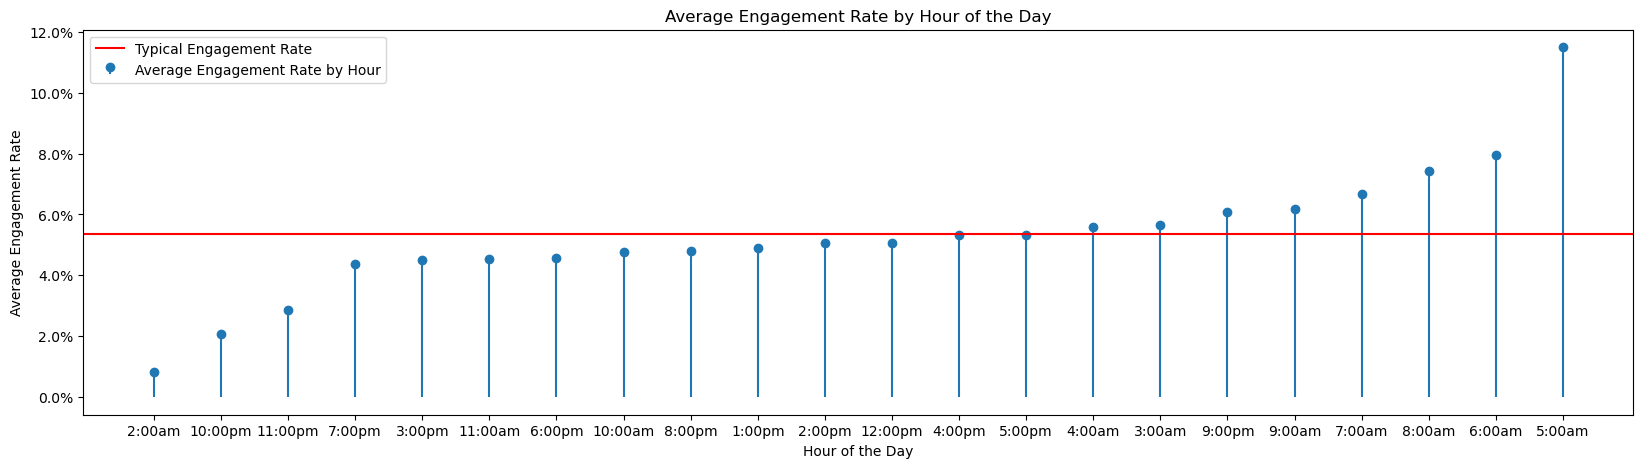

In [21]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.stem("Hour", "Average_Engagement_Rate", data = hours, basefmt = " ")
ax.axhline(y = typicalEngagementRate, color = "r", linestyle = "-")

plt.title("Average Engagement Rate by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Engagement Rate")
plt.gca().yaxis.set_major_formatter(PercentFormatter())

plt.legend(["Typical Engagement Rate", "Average Engagement Rate by Hour"])
plt.show()

From this graph, we can extrapolate that there is a correlation with time of posting and engagement rates. We see that 5:00am specifically has a significantly higher average engagement rate than our global average and other early morning hours such as 6:00am-8:00am aren't far behind. On the flip side, 2:00am possesses the lowest average engagement rate among all hours of the day by a significant margin. 

## 3) How are our game titles doing in terms of social performance? Is there a specific game we should focus more or less on?

To determine how game titles perform on different social media platforms, we can create a graph that displays the average engagement rate for each account for every social media platform they post to. 

<Axes: xlabel='Account'>

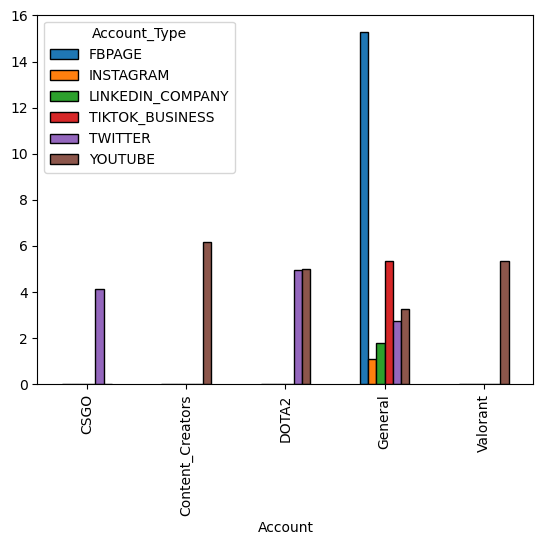

In [22]:
df.groupby([df.Account, df.Account_Type])["Engagement_Rates"].mean().unstack().plot.bar(edgecolor = "black")

We can see that most of the accounts don't post to all the social media platforms they can with the CSGO account only posting to twitter, the Valorant account only posting to Youtube, and the DOTA2 account posting to both. All three game accounts perform close to each other with Valorant slightly edging out the other games. Based on this data, I would say to focus more on Valorant since it's engagement is the highest and focus less on CSGO since it has the lowest engagement rate. This can change in the future, however, with the release of CSGO2 which could skyrocket CSGO discussion on social media.

## 4) What media type performs the best?

We can determine the media type that performs the best by taking the average engagement rate of each type and comparing them to both each other and our global average.

In [23]:
media = df.groupby(df.Media_Type)["Engagement_Rates"].mean()

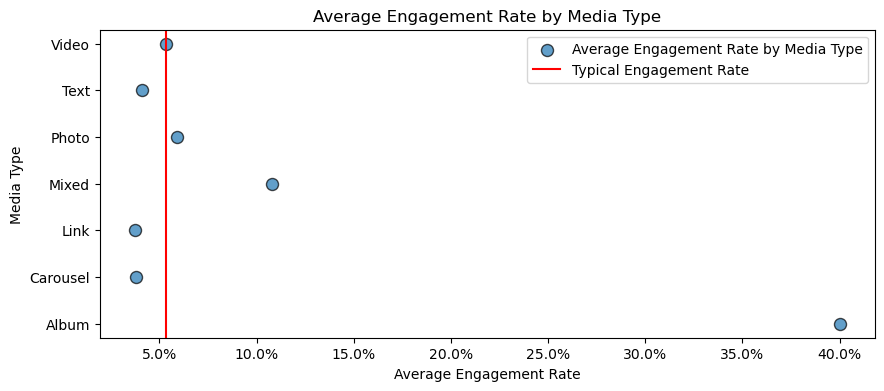

In [24]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.scatter(y = media.index, x = media.values, s=75, alpha=0.7, edgecolor = "black")
ax.axvline(x = typicalEngagementRate, color = "r", linestyle = "-")

plt.title("Average Engagement Rate by Media Type")
plt.xlabel("Average Engagement Rate")
plt.ylabel("Media Type")
plt.gca().xaxis.set_major_formatter(PercentFormatter())

plt.legend(["Average Engagement Rate by Media Type", "Typical Engagement Rate"])
plt.show()

The big takeaway from thsi visualization is the high engagement rate present for album style posting. Albums outperform all other media types by a huge margin far above the global average engagement rate. Mixed and photo media types also perform extremely well with engagement rates above the global average. We can conclude from this graph that albums are the best performing media type.

## 5) What is our best performing campaign?

To determine the best performing campaign, we can take the average engagement rate for each of the campaigns within the dataset and compare them. 

In [25]:
camp = df.groupby(df.Campaign_Name)["Engagement_Rates"].mean()

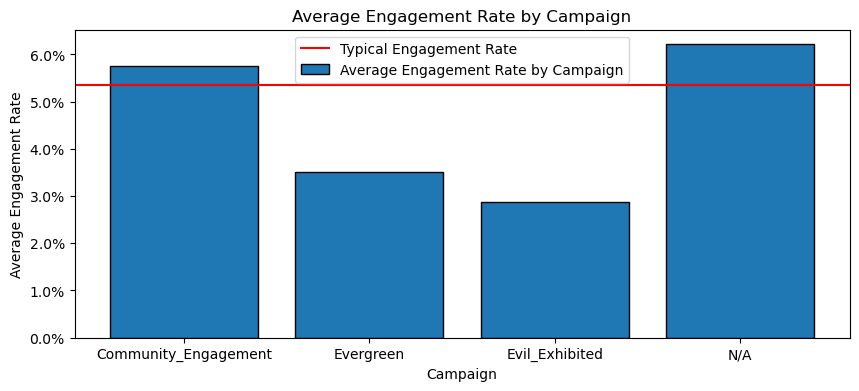

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(camp.index, camp.values, edgecolor = "black")
ax.axhline(y = typicalEngagementRate, color = "r", linestyle = "-")

plt.title("Average Engagement Rate by Campaign")
plt.xlabel("Campaign")
plt.ylabel("Average Engagement Rate")
plt.gca().yaxis.set_major_formatter(PercentFormatter())

plt.legend(["Typical Engagement Rate", "Average Engagement Rate by Campaign"])
plt.show()

As we can see, community engagement and N/A campaigns tend to perform higher than the global average by a small margin. The evil exhibited campaign in comparison underperformed but still achieves a respectable general engagement rate. The best performing campaign within this dataset is N/A unless we are only considering named campaigns in which community engagement has the highest average engagement rate. . 

## 6) Define a posting strategy for our social channels based on your discoveries.

Considering the discoveries made throughout this notebook, a posting strategy that effectively maximizes the average engagement rate of posts will follow these guidelines:

1) Post on either a Tuesday, Thursday, or Sunday
2) Post between the hours of 5:00am and 9:00am
3) Ensure that the post is in the form of an album
4) Post on either Facebook, TikTok, or Youtube

## 7) What suggestions would you give to the social media team if they want to expand their prescence (e.g if our CSGO youtube channel is doing well, should we expand to TikTok)?

The suggestions I would give the social media team if they want to expand their prescence is to expand to expand to Facebook. From the general account statistics, Facebook has the highest average engagement rate compared to all other social medias. Most of the game-specific accounts are only posting to one social media with DOTA2 posting to both twitter and youtube. In this case, I would recommend the Valorant and DOTA2 accounts to expand their prescence to TikTok since they can turn existing Youtube videos and shorts into TikTok videos. For the CSGO account, I would recommend branching out into Facebook to turn tweets into posts and also to Youtube if the Twitter posts consist of a lot of video content.

# Conclusion
Thank you for allowing me the opportunity to engage with the assessment and I hope the analysis was sufficient to proceed to the next interview. I look forward to hearing back from you soon!